# 데이터 추출

In [ ]:
# !pip install ee
# !pip install geemap
# !pip install ipympl

In [1]:
import ee, geemap
import pandas as pd

In [2]:
geemap.ee_initialize()

In [5]:
def addNDVI(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands([ndvi])

In [6]:
def maskS2clouds(image):
    qa = image.select('QA60');
    
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    
    mask = (qa.bitwiseAnd(cloudBitMask).eq(0) and (qa.bitwiseAnd(cirrusBitMask).eq(0)))
        
    return image.updateMask(mask)

In [20]:
# reducePoints의 날짜 추가 코드가 기능하지 않으므로
# 새로운 날짜 추가 기능을 해줄 코드를 작성해야함
## 아래 코드는 한 개 image 대상으로는 돌아가는데 Collection단위로 적용되게 할 방법을 찾아야함

def addDate(image):
    return image.addBands(ee.Date(image.get('system:time_start')).format().getInfo()).rename('DATE')

ee.Date(collection.first().get('system:time_start')).format().getInfo()

'2022-01-01T02:08:26'

In [7]:
def reducePoints(image):
    return image.reduceRegions(
                     collection = points,
                     reducer = ee.Reducer.mean(),
                     scale = 10)
                # .copyProperties(image, ['system:time_start'])\
                # .set('DATE', image.date().format('YYYY-MM-dd'))

In [8]:
table = geemap.shp_to_ee('Tower_52N_mod_B5_30.shp')
points = ee.FeatureCollection(table)

geometry = geemap.geojson_to_ee('korea.geojson')

start_date = '2022-01-01'
end_date = '2022-02-01'

collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
       .select(['B2', 'B3', 'B4', 'B8', 'QA60'])
       .filterBounds(geometry)
       .filterDate(start_date, end_date)
       .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 10)
       .map(addNDVI)
       .map(maskS2clouds)
)

In [9]:
result = collection.map(reducePoints).flatten()

# 데이터 저장 및 데이터프레임 생성

In [11]:
# FeatureCollection -> csv로 내보내기
geemap.ee_to_csv(result, filename='220101-220201.csv')

Generating URL ...
Please wait ...
Data downloaded to C:\Users\user\Desktop\산림과학원\221129 GEE-Python API\220101-220201.csv


In [10]:
# FeatureCollection -> DataFrame으로 변환
result_df = geemap.ee_to_df(result)

Exception: Collection query aborted after accumulating over 5000 elements.

In [12]:
# 내보낸 csv -> DataFrame으로 가져오기
result_df = pd.read_csv('220101-220201.csv', encoding='utf-8')

## NA값 제거 및 컬럼 이름 변경

In [13]:
S2 = result_df[['Location', 'BUFF_DIST', 'B2', 'B3', 'B4', 'B8', 'NDVI']].dropna() 

In [14]:
S2.rename(columns={'B2':'Blue', 'B3':'Green', 'B4':'Red', 'B8':'NIR'}, inplace=True)

In [15]:
S2.head(6)

,Location,BUFF_DIST,Blue,Green,Red,NIR,NDVI
865,AMD,5,69.502488,179.348259,157.636816,1824.378109,0.843008
874,AMD,10,75.086250,192.245000,167.407500,1870.890000,0.838265
883,AMD,15,69.702282,193.190317,160.622705,1883.075125,0.845583
892,AMD,20,62.674083,194.796929,153.726418,1917.150736,0.854010
901,AMD,25,56.926379,195.976931,147.907121,1939.359278,0.860170
910,AMD,30,52.770077,197.076270,142.614335,1960.400835,0.865630


---

# 관측 지점별 관측 개수 시각화

In [14]:
import matplotlib.pyplot as plt

In [ ]:
# 그래프에 한글 출력 시 사용
from matplotlib import font_manager, rc

font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

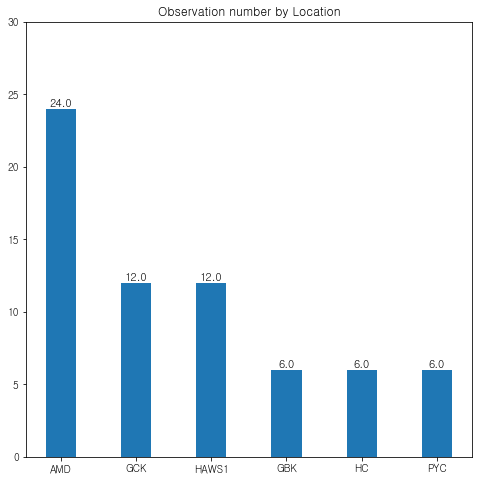

In [135]:
targetColumn = 'Location'
counts = S2[targetColumn].value_counts()

plt.figure(figsize=(8, 8))
plt.title('Observation number by Location')
bars = plt.bar(counts.index, counts, width=0.4)
plt.ylim(0, counts.max()*1.25) 

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, 
             height, f'{height:.1f}', ha='center', va='bottom', size = 11)
    
plt.show()

# 관측 지점별 위성 사진 확인

In [23]:
start_date = '2022-01-01'
end_date = '2022-02-01'

temp = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
       .select(['B2', 'B3', 'B4', 'B8', 'QA60'])
       .filterDate(start_date, end_date)
       .filterBounds(ee.Geometry.Point(point).buffer(50).bounds())
       .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 10)
       .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 10)
       .map(addNDVI)
       .map(maskS2clouds))

ee.Date(temp.first().get('system:time_start')).format().getInfo()

'2022-01-07T02:27:29'

In [24]:
coords = result_df[['Location', 'Lon', 'Lat']].drop_duplicates()

In [25]:
coords_dict = {'GBK_coord' : [coords.iloc[0, 1], coords.iloc[0, 2]],
               'GBK_coord' : [coords.iloc[1, 1], coords.iloc[1, 2]],
               'WD_coord'  : [coords.iloc[2, 1], coords.iloc[2, 2]],
               'HC_coord'  : [coords.iloc[3, 1], coords.iloc[3, 2]],
               'PYC_coord' : [coords.iloc[4, 1], coords.iloc[4, 2]],
               'SC_coord'  : [coords.iloc[5, 1], coords.iloc[5, 2]],
               'JJ_coord'  : [coords.iloc[6, 1], coords.iloc[6, 2]],
               'GCK_coord' : [coords.iloc[7, 1], coords.iloc[7, 2]],
             'HAWS1_coord' : [coords.iloc[8, 1], coords.iloc[8, 2]], }

vis = {'bands': ['B4', 'B3', 'B2'],
       'min': 0,
       'max': 3000,
       'gamma':1.4  }

In [26]:
Map = geemap.Map()
point = coords_dict['GBK_coord']
Map.setCenter(point[0], point[1], 17)
Map.addLayer(ee.Image(temp.first()), vis, 'Sentinel-2')
Map.addLayer(ee.Image().paint(ee.Geometry.Point(point).buffer(250).bounds(), 0, 1), {'palette': 'FF0000'}, 'Box Outline')
Map.addLayer(ee.Image().paint(ee.Geometry.Point(point).buffer(30), 0, 1), {'palette': 'FFFF00'}, 'Center point')
Map

Map(center=[36.5056, 126.359], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chi…